# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'gsk3_jnk3_qed_sa')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'gsk3')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 781797
Number of vocabulary: 53687
Maximum of seqlen: 40


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 40,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'gsk3_jnk3_qed_sa', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_gsk3 as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward()

In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft, zeta=0.9999)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                  gsk_list,
                  execution_times, filepath):
    
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "GSK3":gsk_list,
                               "EXEC_TIME":execution_times})
    
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 50
behavior_stepsize = 20

[0001] rl_loss: 2.385	reconst_loss: 2.304	entropy_loss: 0.081	reward: 0.904	tau: 0.306	(24.169 sec)
[0002] rl_loss: 2.118	reconst_loss: 2.033	entropy_loss: 0.086	reward: 0.681	tau: 0.310	(48.612 sec)
[0003] rl_loss: 2.533	reconst_loss: 2.449	entropy_loss: 0.084	reward: 1.194	tau: 0.319	(73.554 sec)
[0004] rl_loss: 2.700	reconst_loss: 2.610	entropy_loss: 0.090	reward: 0.835	tau: 0.324	(98.175 sec)
[0005] rl_loss: 2.681	reconst_loss: 2.586	entropy_loss: 0.095	reward: 0.961	tau: 0.330	(122.760 sec)
[0006] rl_loss: 3.076	reconst_loss: 2.987	entropy_loss: 0.089	reward: 0.805	tau: 0.335	(147.119 sec)
[0007] rl_loss: 2.862	reconst_loss: 2.764	entropy_loss: 0.098	reward: 1.031	tau: 0.342	(172.207 sec)
[0008] rl_loss: 2.982	reconst_loss: 2.879	entropy_loss: 0.104	reward: 1.213	tau: 0.351	(196.673 sec)
[0009] rl_loss: 4.312	reconst_loss: 4.207	entropy_loss: 0.105	reward: 1.647	tau: 0.364	(221.353 sec)
[0010] rl_loss: 2.034	reconst_loss: 1.925	entropy_loss: 0.109	reward: 0.748	tau: 0.367	(245.757

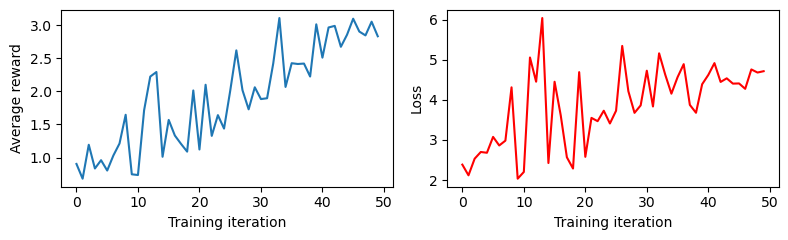

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.92it/s]


Sample trajectories: 100
[0.050]    CCSC=NC(C1=CC=C(F)C=C1Cl)=CNC2=C(F)C=CC=C2F
[0.050]    NC=NC(C1CCOC2C1)=CN=NN2OCO
[0.540]    CNC1=NC(=NC=C1Cl)NC2=CC=C(C=C2OC)OCCC(C=C)C(N)=O
[0.010]    O=CC1=CC=CC=C1NC(=O)NCCCCCNC(=S)N2CCCCC3=CC=CC=C32
[0.010]    CC=CC(Cl)=COCOC1OCCCCCCO1
[0.020]    CC1=CC=C(C=C1)N2N=NN=C2C3=NC(=NO3)C4=CC=C(C=C4)C(F)(F)F
[0.110]    OC1=CC=C(C=C1)N2C=C(N=N2)C3=CC=C(C=C3)OC4=CC=CC=C4
[0.120]    CCCC1CNC(=O)N=NN1C2=NC(=CS2)C3=CC=CC(F)=C3
[0.050]    CN=CN(N=N)SC1=NC=NC2=C1C(=CS2)C3=CC=C(Br)C=C3
[0.140]    O=C(C(F)(F)F)C1C=CC=C1NC=NC=C(C(=O)N2CCOCC2)C=C3C=CCCN3CC4=CN=CN=C4
[0.070]    O=C(NCC1=CC2=CC=C1Cl)CN2
[0.020]    COC1=CC=C(C=C12)OCCO2
[0.100]    CC(C)N(NC(=O)C(C)(C)N)C(=O)C1=CNC2=CC=CC=C12
[0.010]    N1=C(F)C=C1C=O
[0.030]    CC1=CC=CC=C1N2C=CN=C2CC(=O)N3CCN(CC3)C4=CC=C(C=C4)C(N)=O
[0.050]    C1C=CC=NC1CCCCC=CNNN=CC=CC=CCN2N=CC=C2
[0.620]    C1=CC(=NN1)CSC2=NN=C(O2)C3=CC=NC=C3
[0.070]    C12=CN=C3C=CC=CC3=C1C4=CC=CC=C24
[0.060]    CCCCOC(=O)C(=O)NC1=CC(=CC=N1)NC(C

[0079] rl_loss: 3.472	reconst_loss: 3.115	entropy_loss: 0.358	reward: 3.658	tau: 1.562	(1958.391 sec)
[0080] rl_loss: 3.326	reconst_loss: 2.970	entropy_loss: 0.356	reward: 3.456	tau: 1.581	(1984.007 sec)
[0081] rl_loss: 3.643	reconst_loss: 3.278	entropy_loss: 0.365	reward: 3.872	tau: 1.604	(2010.498 sec)
[0082] rl_loss: 3.664	reconst_loss: 3.300	entropy_loss: 0.365	reward: 3.709	tau: 1.625	(2038.897 sec)
[0083] rl_loss: 3.920	reconst_loss: 3.555	entropy_loss: 0.365	reward: 3.623	tau: 1.645	(2065.292 sec)
[0084] rl_loss: 3.656	reconst_loss: 3.286	entropy_loss: 0.370	reward: 3.677	tau: 1.666	(2091.646 sec)
[0085] rl_loss: 3.427	reconst_loss: 3.048	entropy_loss: 0.379	reward: 3.847	tau: 1.687	(2116.726 sec)
[0086] rl_loss: 3.169	reconst_loss: 2.788	entropy_loss: 0.381	reward: 3.718	tau: 1.708	(2145.022 sec)
[0087] rl_loss: 3.322	reconst_loss: 2.937	entropy_loss: 0.385	reward: 3.788	tau: 1.729	(2171.113 sec)
[0088] rl_loss: 3.338	reconst_loss: 2.950	entropy_loss: 0.389	reward: 3.784	tau: 1

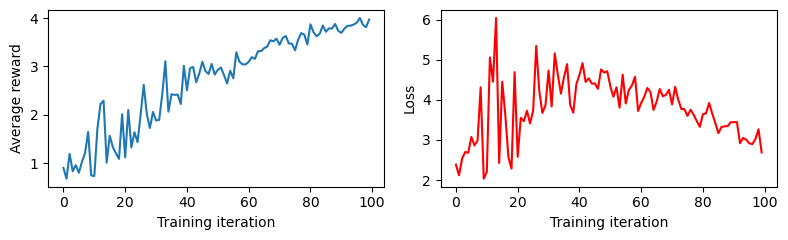

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.36it/s]


Sample trajectories: 100
[0.030]    CC(=O)C=CNCNCC=C1C=CCN=C1C2=CC=CC=C2F
[0.940]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N4C=CN=C4
[0.050]    S1(=NC=C1)C2=CC=NC=C2
[0.800]    CC1=CC=CC(=C1)NC2=NC=CC(=N2)NC3=CC=CC=C3F
[0.990]    O=[N+1]([O-1])C1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.050]    OCCCC1(O)C=C2C(O)C([N+1](=O)[O-1])=NC2=C1
[0.000]    CN1C=C(C2=CC=CC=C21)NS(=O)(=O)C3=CC=C(C=C3)CN(C)NC(=O)CCC4=CC=C(F)C=C4
[0.010]    CS(=O)(=O)N1CC(C1)NC(=O)C2=CSN=N2
[0.615]    O=C1NC2=CC=CC=C2C1=CC3=CC=C(F)C=C3
[0.970]    COC1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.070]    CN1CCN(CC12)CC3NC4CC=C3N=C24
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N4C=CC=C4
[1.000]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=COC5=CC=CC=C45
[0.980]    C1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.730]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C=NNNCCCN4CCOCC4NC(=O)C5=CC=CC=N5
[0.820]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)ONCC4CCNCC4=N
[0.000]    COC1=CC(=CC(OC)=C1OC)CCCN2CCN(CC2)C3=CC=C(C=C3)[N+1](=O)[O-1]

[0124] rl_loss: 2.301	reconst_loss: 1.771	entropy_loss: 0.530	reward: 4.062	tau: 2.429	(3238.689 sec)
[0125] rl_loss: 2.040	reconst_loss: 1.506	entropy_loss: 0.534	reward: 4.103	tau: 2.445	(3271.612 sec)
[0126] rl_loss: 1.853	reconst_loss: 1.315	entropy_loss: 0.538	reward: 4.122	tau: 2.462	(3300.414 sec)
[0127] rl_loss: 2.118	reconst_loss: 1.575	entropy_loss: 0.543	reward: 4.140	tau: 2.479	(3329.452 sec)
[0128] rl_loss: 2.229	reconst_loss: 1.686	entropy_loss: 0.543	reward: 4.104	tau: 2.495	(3360.706 sec)
[0129] rl_loss: 2.094	reconst_loss: 1.546	entropy_loss: 0.548	reward: 4.154	tau: 2.512	(3392.284 sec)
[0130] rl_loss: 2.192	reconst_loss: 1.642	entropy_loss: 0.550	reward: 4.091	tau: 2.528	(3420.289 sec)
[0131] rl_loss: 2.191	reconst_loss: 1.640	entropy_loss: 0.551	reward: 4.084	tau: 2.543	(3452.347 sec)
[0132] rl_loss: 2.103	reconst_loss: 1.542	entropy_loss: 0.561	reward: 4.149	tau: 2.559	(3482.096 sec)
[0133] rl_loss: 2.047	reconst_loss: 1.483	entropy_loss: 0.564	reward: 4.148	tau: 2

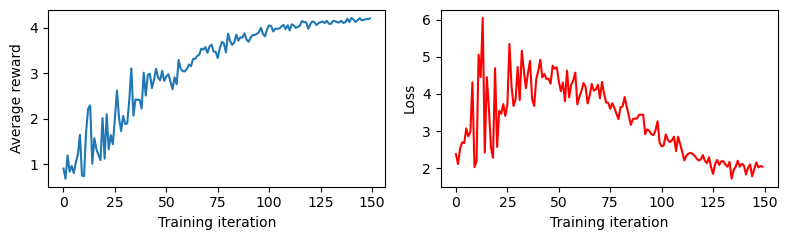

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.71it/s]


Sample trajectories: 100
[0.950]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SCC4=CC=C(F)C=C4
[1.000]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=COC5=CC=CC=C45
[0.900]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N=CC4=CC=C(Cl)C=C4
[0.140]    CCCCOC1=CC(C#N)=NC(=N1)NC2=CC=CC(=C2)[N+1](=O)[O-1]
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=NCCO4
[0.870]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CCOC4=CC=CC(=C4)C(F)(F)F
[0.930]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC(Cl)=CC=C4Cl
[0.030]    CSC1=CC=C(C=C1)CC2SC(=O)NC2=O
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SCC4=CC=CC=C4
[0.000]    NC(C)=O
[0.760]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N4C=C(N=N4)C=CC(O)=CC(C(C)CC)=CC(=O)NC5=CC=CC=C5
[0.000]    N#CCC=CCl
[0.900]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C=CC4=CC=CC=C4
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SCC4=CC=CC=C4
[0.870]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NC4=CC=C5OCCOC5=C4
[0.080]    COC1=CC=C2C(=CNC2=C1)C(=O)C3=CC4=CC=CC=C4O3
[0.900]    C1N2C=C(C3=CC=CC=C32)C4=C(C(=O

[0170] rl_loss: 1.949	reconst_loss: 1.250	entropy_loss: 0.699	reward: 4.268	tau: 3.080	(4670.362 sec)
[0171] rl_loss: 2.174	reconst_loss: 1.471	entropy_loss: 0.703	reward: 4.229	tau: 3.091	(4705.201 sec)
[0172] rl_loss: 2.101	reconst_loss: 1.398	entropy_loss: 0.703	reward: 4.206	tau: 3.102	(4735.210 sec)
[0173] rl_loss: 2.066	reconst_loss: 1.357	entropy_loss: 0.709	reward: 4.251	tau: 3.114	(4764.280 sec)
[0174] rl_loss: 1.824	reconst_loss: 1.114	entropy_loss: 0.710	reward: 4.302	tau: 3.126	(4797.004 sec)
[0175] rl_loss: 1.939	reconst_loss: 1.220	entropy_loss: 0.719	reward: 4.230	tau: 3.137	(4831.290 sec)
[0176] rl_loss: 1.809	reconst_loss: 1.090	entropy_loss: 0.719	reward: 4.255	tau: 3.148	(4860.773 sec)
[0177] rl_loss: 2.008	reconst_loss: 1.287	entropy_loss: 0.721	reward: 4.256	tau: 3.159	(4893.263 sec)
[0178] rl_loss: 1.938	reconst_loss: 1.209	entropy_loss: 0.729	reward: 4.277	tau: 3.170	(4922.667 sec)
[0179] rl_loss: 1.924	reconst_loss: 1.195	entropy_loss: 0.729	reward: 4.278	tau: 3

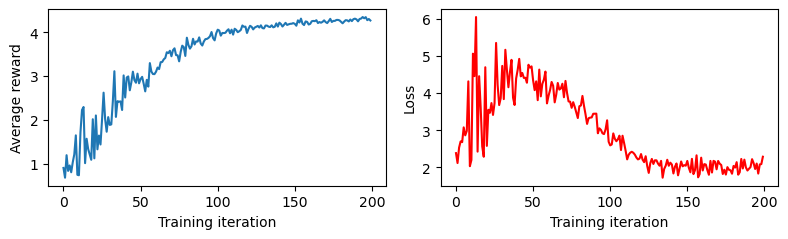

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.85it/s]


Sample trajectories: 100
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC(N)=C4
[0.900]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C=CO
[0.920]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NCCN4CCOCC4
[0.850]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N4C=CC=CC4CN5CCOC6(C5)CCCC6
[0.940]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC=C(O)C=C4
[0.900]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C=CC4=CC=CC=C4
[0.000]    CC(C)C1=CC(O)=CC=C1OC2=CC=C(C=C2)[N+1](=O)[O-1]
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N4CC5=CC=CC=C5C4
[0.890]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CNC5=NC=CC=C45
[0.850]    CCCN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NC4=CC=CC(OC)=C4
[0.030]    CNC=CCCSC=NN=CC=C(C1CC1)NCC2=CC=CC(=C2)OC3=CC=CC(C)=C3
[0.910]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NCCC4=CC=CC=C4
[0.880]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NCCC4=CNC5=CC=CC=C45
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=C(Cl)C=C4
[0.910]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4CCCC4
[0.980]    CN1C=C(C2=CC=CC=C21)C3=

[0220] rl_loss: 2.104	reconst_loss: 1.227	entropy_loss: 0.877	reward: 4.349	tau: 3.561	(6238.894 sec)
[0221] rl_loss: 2.368	reconst_loss: 1.491	entropy_loss: 0.877	reward: 4.311	tau: 3.568	(6272.519 sec)
[0222] rl_loss: 2.167	reconst_loss: 1.286	entropy_loss: 0.880	reward: 4.336	tau: 3.576	(6307.503 sec)
[0223] rl_loss: 2.067	reconst_loss: 1.180	entropy_loss: 0.887	reward: 4.375	tau: 3.584	(6335.860 sec)
[0224] rl_loss: 2.351	reconst_loss: 1.463	entropy_loss: 0.888	reward: 4.371	tau: 3.592	(6364.244 sec)
[0225] rl_loss: 2.344	reconst_loss: 1.451	entropy_loss: 0.893	reward: 4.326	tau: 3.599	(6398.955 sec)
[0226] rl_loss: 2.105	reconst_loss: 1.212	entropy_loss: 0.894	reward: 4.377	tau: 3.607	(6433.618 sec)
[0227] rl_loss: 2.026	reconst_loss: 1.126	entropy_loss: 0.900	reward: 4.363	tau: 3.614	(6462.616 sec)
[0228] rl_loss: 2.126	reconst_loss: 1.221	entropy_loss: 0.905	reward: 4.372	tau: 3.622	(6491.609 sec)
[0229] rl_loss: 2.280	reconst_loss: 1.372	entropy_loss: 0.908	reward: 4.338	tau: 3

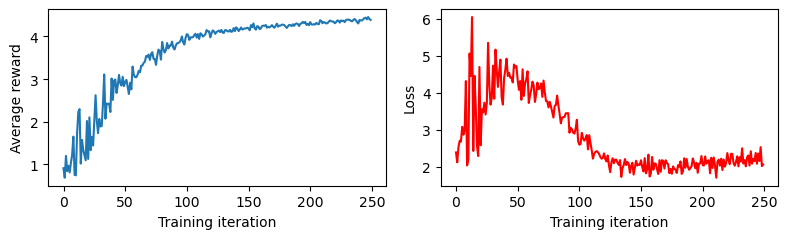

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.83it/s]


Sample trajectories: 100
[0.920]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CCOC=C
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC=CC=C4
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=C5C=CC=CC5=C4
[1.000]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=COC5=CC=CC=C45
[0.910]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4CC4
[0.190]    NC1=NC=NC(=N1)NC2=CC=C(C=C2)C3CCNCC3
[0.050]    COC=CC(OC(C)C)=CC(OC)=N
[0.000]    CN1CCCN(CC1)C=C(C2=CC=CC=C2)CC3=CC(O)=CC=C3
[0.730]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NCC4=CC=CC=C4OOCC5CCCCC5C(=O)C(F)NNC(=O)NC(C)C(C(=O)N6CCCCC6)=C(CCCN=C(N)N)OS(N)(=O)=O
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SC4=CC=CC=C4O
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=C(F)C=C4F
[0.860]    CC1=CC=CC(=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC(F)=C4
[0.930]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=C5N=CSC5=C4
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CS4
[0.430]    CN1C=C(C2=CC=CC=C21)C3=C(C(=

[0270] rl_loss: 2.257	reconst_loss: 1.209	entropy_loss: 1.048	reward: 4.446	tau: 3.892	(7725.854 sec)
[0271] rl_loss: 2.362	reconst_loss: 1.309	entropy_loss: 1.053	reward: 4.431	tau: 3.897	(7754.418 sec)
[0272] rl_loss: 2.188	reconst_loss: 1.130	entropy_loss: 1.058	reward: 4.453	tau: 3.903	(7780.048 sec)
[0273] rl_loss: 2.371	reconst_loss: 1.312	entropy_loss: 1.059	reward: 4.430	tau: 3.908	(7808.809 sec)
[0274] rl_loss: 2.357	reconst_loss: 1.297	entropy_loss: 1.059	reward: 4.428	tau: 3.913	(7836.466 sec)
[0275] rl_loss: 2.313	reconst_loss: 1.247	entropy_loss: 1.066	reward: 4.432	tau: 3.918	(7867.443 sec)
[0276] rl_loss: 2.202	reconst_loss: 1.134	entropy_loss: 1.068	reward: 4.434	tau: 3.924	(7893.387 sec)
[0277] rl_loss: 2.452	reconst_loss: 1.383	entropy_loss: 1.068	reward: 4.479	tau: 3.929	(7920.237 sec)
[0278] rl_loss: 2.577	reconst_loss: 1.502	entropy_loss: 1.076	reward: 4.495	tau: 3.935	(7951.128 sec)
[0279] rl_loss: 2.584	reconst_loss: 1.510	entropy_loss: 1.074	reward: 4.481	tau: 3

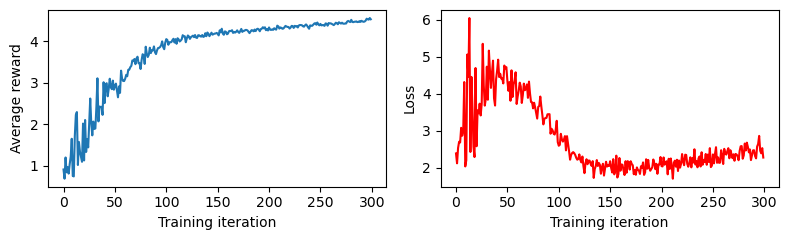

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.11it/s]


Sample trajectories: 100
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4CC5=CC=CC=C5
[0.740]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C=CCCCSCOCC4=CC=C(N=C4)C5=CC=CN=C5F
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SC4=CC=CC=C4
[0.910]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=NNN=N4
[0.920]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)OCCN4CCCCC4
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)O
[1.000]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4Br
[0.920]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=NC=C4
[0.910]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4COC=CC=C5C=CC6=CC=CC=C5O6
[0.940]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=C5OCOC5=C4
[0.920]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)OC(C)=NN
[0.880]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NCCC4=CNC5=CC=CC=C45
[0.930]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)NCCCN4CCOCC4
[0.280]    NC1=NC=C(C=C1OC(F)F)C2=CC=C3C(=CC=CC3=C2)C4=CC=CC(Cl)=C4
[0.710]    NC1=NC=CC(=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCN(CC4)CC5=CC=CC=C5
[

[0320] rl_loss: 2.623	reconst_loss: 1.407	entropy_loss: 1.217	reward: 4.608	tau: 4.138	(9128.799 sec)
[0321] rl_loss: 2.611	reconst_loss: 1.388	entropy_loss: 1.223	reward: 4.627	tau: 4.143	(9152.073 sec)
[0322] rl_loss: 2.620	reconst_loss: 1.387	entropy_loss: 1.232	reward: 4.620	tau: 4.148	(9177.167 sec)
[0323] rl_loss: 2.464	reconst_loss: 1.236	entropy_loss: 1.228	reward: 4.574	tau: 4.152	(9206.933 sec)
[0324] rl_loss: 2.573	reconst_loss: 1.339	entropy_loss: 1.234	reward: 4.603	tau: 4.157	(9233.933 sec)
[0325] rl_loss: 2.496	reconst_loss: 1.266	entropy_loss: 1.230	reward: 4.597	tau: 4.161	(9263.114 sec)
[0326] rl_loss: 2.729	reconst_loss: 1.495	entropy_loss: 1.235	reward: 4.601	tau: 4.166	(9285.918 sec)
[0327] rl_loss: 2.785	reconst_loss: 1.544	entropy_loss: 1.241	reward: 4.628	tau: 4.170	(9312.922 sec)
[0328] rl_loss: 2.801	reconst_loss: 1.551	entropy_loss: 1.251	reward: 4.627	tau: 4.175	(9342.043 sec)
[0329] rl_loss: 2.788	reconst_loss: 1.542	entropy_loss: 1.246	reward: 4.584	tau: 4

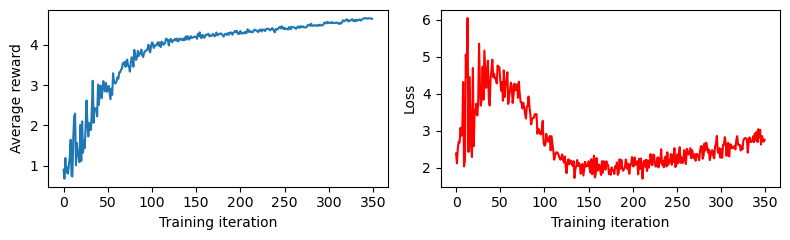

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.72it/s]


Sample trajectories: 100
[0.330]    CN1C=C(N=N1)NC2=NC=NC=C2N=C3NCCSC=NC4=CC=CC=C4C3=S
[0.950]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CN4
[0.930]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C=CCC=CC=CCCCN4CCCCC4
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N=NC4=CC=CC=C4C5=CC(F)=CC=C5F
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N=NC4=CC=C(Br)C=C4
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=COCCO4
[0.050]    C1N2C=C(C3=CC=CC=C32)C=CC1CN4CCN(CC4)C5=CC=CC(Cl)=C5F
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)O
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC=CC=C4O
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CCCN4CCOCC4
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CO4
[0.850]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC=CC=C4C5=NNN=N5
[1.000]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC(Cl)=C4
[0.950]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CCCCC4=CC=CC=C4
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N
[0.840]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)OC4=C

[0372] rl_loss: 2.736	reconst_loss: 1.347	entropy_loss: 1.389	reward: 4.693	tau: 4.343	(10521.114 sec)
[0373] rl_loss: 2.798	reconst_loss: 1.405	entropy_loss: 1.393	reward: 4.672	tau: 4.346	(10547.049 sec)
[0374] rl_loss: 3.091	reconst_loss: 1.702	entropy_loss: 1.389	reward: 4.689	tau: 4.350	(10573.517 sec)
[0375] rl_loss: 3.347	reconst_loss: 1.958	entropy_loss: 1.390	reward: 4.680	tau: 4.353	(10598.068 sec)
[0376] rl_loss: 2.902	reconst_loss: 1.500	entropy_loss: 1.403	reward: 4.681	tau: 4.356	(10623.681 sec)
[0377] rl_loss: 2.775	reconst_loss: 1.374	entropy_loss: 1.401	reward: 4.682	tau: 4.360	(10652.714 sec)
[0378] rl_loss: 2.879	reconst_loss: 1.478	entropy_loss: 1.401	reward: 4.698	tau: 4.363	(10680.636 sec)
[0379] rl_loss: 3.391	reconst_loss: 1.985	entropy_loss: 1.406	reward: 4.674	tau: 4.366	(10704.934 sec)
[0380] rl_loss: 3.006	reconst_loss: 1.602	entropy_loss: 1.404	reward: 4.691	tau: 4.369	(10729.754 sec)
[0381] rl_loss: 3.484	reconst_loss: 2.068	entropy_loss: 1.415	reward: 4.6

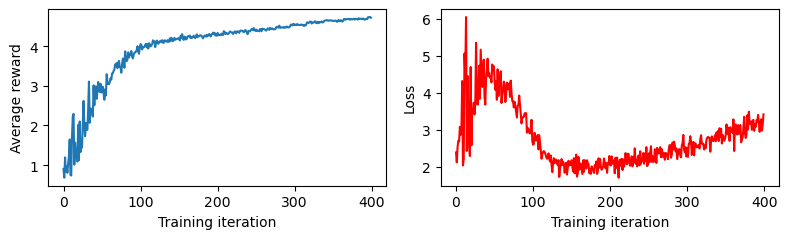

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.41it/s]


Sample trajectories: 100
[0.850]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=NC=CN4
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC5=C4OCO5
[0.950]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SCC4=CC=C(F)C=C4
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CSC=C4O
[0.750]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C#CCN(C=O)CC4=CC=NC=C4
[0.960]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC=CC=C4Br
[0.070]    CCOC1=CC=CC(=C1)C(=O)C2=CN=CC(=N2)COC3=CC=CC=C3OC
[0.060]    C[N+1]1=CC=CC(=C1)C=CC2=CC=NC=C2
[0.950]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC4=CC=CC5=CC=CC=C45
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CSC5=CC=CC=C45
[0.880]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4CCOCC4
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CN4C
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4CN5CCCCC5
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4CO
[0.920]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)OCCN4CCOCC4
[0.950]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SCC4=CC=C(F)

[0424] rl_loss: 3.625	reconst_loss: 2.082	entropy_loss: 1.544	reward: 4.737	tau: 4.496	(11902.921 sec)
[0425] rl_loss: 3.646	reconst_loss: 2.097	entropy_loss: 1.549	reward: 4.752	tau: 4.498	(11930.682 sec)
[0426] rl_loss: 3.272	reconst_loss: 1.727	entropy_loss: 1.545	reward: 4.744	tau: 4.501	(11955.217 sec)
[0427] rl_loss: 3.748	reconst_loss: 2.200	entropy_loss: 1.549	reward: 4.738	tau: 4.503	(11983.979 sec)
[0428] rl_loss: 3.408	reconst_loss: 1.861	entropy_loss: 1.548	reward: 4.748	tau: 4.506	(12008.400 sec)
[0429] rl_loss: 3.660	reconst_loss: 2.114	entropy_loss: 1.546	reward: 4.750	tau: 4.508	(12033.874 sec)
[0430] rl_loss: 3.416	reconst_loss: 1.870	entropy_loss: 1.546	reward: 4.746	tau: 4.510	(12060.901 sec)
[0431] rl_loss: 3.561	reconst_loss: 2.016	entropy_loss: 1.544	reward: 4.738	tau: 4.513	(12090.493 sec)
[0432] rl_loss: 3.662	reconst_loss: 2.105	entropy_loss: 1.556	reward: 4.765	tau: 4.515	(12114.613 sec)
[0433] rl_loss: 3.548	reconst_loss: 1.987	entropy_loss: 1.561	reward: 4.7

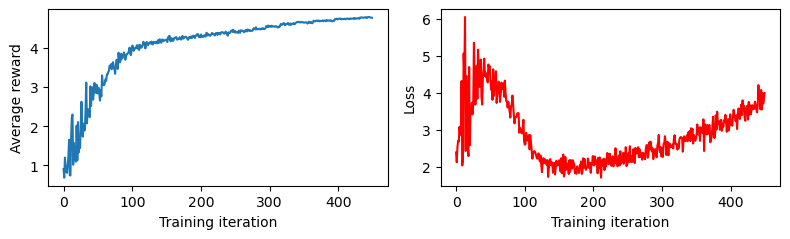

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.92it/s]


Sample trajectories: 100
[0.000]    CN1C=NC2=CC=CC=C21
[0.040]    CN1C=C(C2=CC=CC=C21)C=CCl
[0.600]    CC1=CC=NC(=N1)C2=CC=C3NN=C(C3=C2)C4=CN=CC(=N4)NC=N
[0.120]    COC1=CC=CC(=C1)NCNC2CCCCCCC2SC3=NC4=CC=CC=C4N3
[0.100]    CN1C=C(C2=CC=CC3=C21)C=C(C=C3S)NC4CCC4
[0.020]    C12CCN1N3CCCC3C=CC2=C
[1.000]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)[N+1](=O)[O-1]
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4
[1.000]    N#CC1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCOC4=C3
[0.940]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=CC=C4OCC(F)(F)F
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C(O)=N
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C(N)=N
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C(N)=N
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC=C5C=CC=CC5=C4
[0.990]    N#CC1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.900]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=C5C=CC=C4C=CCCC=CC=NN5C6=COC=C6
[0.890]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)CC=CC4=CC=CS4
[0.960]    CN1C=C(C2=CC=CC=C

[0476] rl_loss: 4.139	reconst_loss: 2.486	entropy_loss: 1.652	reward: 4.770	tau: 4.606	(13310.385 sec)
[0477] rl_loss: 3.876	reconst_loss: 2.229	entropy_loss: 1.647	reward: 4.769	tau: 4.608	(13340.660 sec)
[0478] rl_loss: 4.493	reconst_loss: 2.845	entropy_loss: 1.648	reward: 4.770	tau: 4.610	(13365.857 sec)
[0479] rl_loss: 4.580	reconst_loss: 2.934	entropy_loss: 1.646	reward: 4.777	tau: 4.611	(13395.952 sec)
[0480] rl_loss: 4.696	reconst_loss: 3.053	entropy_loss: 1.643	reward: 4.782	tau: 4.613	(13420.022 sec)
[0481] rl_loss: 4.266	reconst_loss: 2.611	entropy_loss: 1.656	reward: 4.790	tau: 4.615	(13446.174 sec)
[0482] rl_loss: 4.489	reconst_loss: 2.842	entropy_loss: 1.646	reward: 4.791	tau: 4.616	(13477.509 sec)
[0483] rl_loss: 3.978	reconst_loss: 2.324	entropy_loss: 1.654	reward: 4.784	tau: 4.618	(13507.676 sec)
[0484] rl_loss: 4.371	reconst_loss: 2.720	entropy_loss: 1.651	reward: 4.782	tau: 4.620	(13533.498 sec)
[0485] rl_loss: 4.981	reconst_loss: 3.342	entropy_loss: 1.638	reward: 4.7

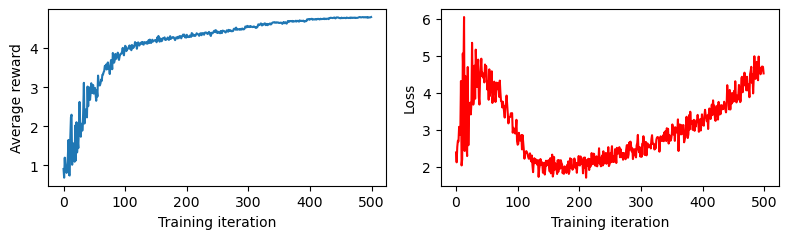

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.09it/s]


Sample trajectories: 100
[0.150]    CN1C=C(C2=C3C=CC=C21)C=CCCCN3C4=CSC=C4OCC5CC5OCC=C
[0.990]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)Br
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)[O-1]
[0.970]    FC1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.390]    CN1C=C(C2=CC=CC3=C21)C4=C(C(=O)NC4=O)SC=CC=CC=C3
[0.040]    C1N2C=C(C3=CC=CC=C32)C=CSN1C4CCN(C)CC4
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=COCCO4
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SC4=CC=CC=C4
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)[O-1]
[0.970]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)N=C
[0.970]    FC1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCCOC4=C3
[0.130]    COC1=CC=C(C=C1)C=NNC(N2C=CN=C2)C3=CC=CN=C3CCCCCCC4=CC=CC=C4Cl
[1.000]    N#CC1=CC=C(C=C1)CSC2=NN=C(O2)C3=CC=C4OCOC4=C3
[0.070]    OCCOC1=CC=CC=C1NC2=NC=C(Br)C=N2
[0.980]    CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)SC4=CC=CC=C4
[0.070]    CN1C=C(C2=CC=CC=C21)C=C(C(=O)OCC3C)OC4=NC=CC=C34
[0.060]    CN(C1=NC2=CC=CC=C2O1)CCCCOC3=CC=C(C=C3)C=NNC(=S)NC4=CC=CC=C4O
[

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

gsk_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.2
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_gsk = 0.
    
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, s_gsk = my_reward_ft(sm, debug=True)
                print(f"[{s_gsk:.3f}]    {sm}")
                avg_gsk += s_gsk
            avg_gsk /= len(smiles_cur)
    
    ## append - binding affinity values
    gsk_list.append(avg_gsk)

    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                      gsk_list,
                      execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

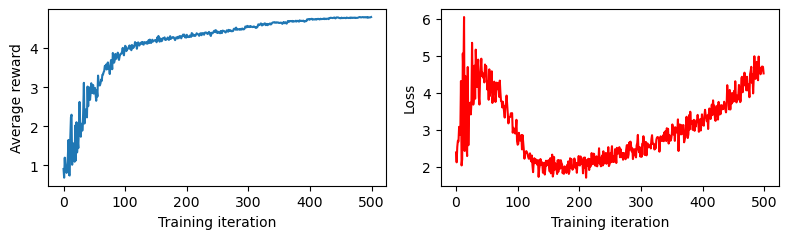

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                           gsk_list,
                           execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 6)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  GSK3   EXEC_TIME
0  0.904051  2.384719      2.304028      0.080691   0.0   24.169131
1  0.681330  2.118371      2.032792      0.085579   0.0   48.611531
2  1.193897  2.532639      2.448982      0.083657   0.0   73.554196
3  0.835491  2.699956      2.610346      0.089610   0.0   98.174693
4  0.960528  2.680577      2.585764      0.094813   0.0  122.759596


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [10:41<00:00, 46.73it/s]


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/gsk3/smi_after.csv
